In [8]:
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *

data = {
    0.25: load_data('../stats/fpm_6_x0.25.json'),
    0.5: load_data('../stats/fpm_6_x0.5.json'),
    1: load_data('../stats/fpm_6_x1.json'),
    2: load_data('../stats/fpm_6_x2.json'),
    3: load_data('../stats/fpm_6_x3.json'),
    # 'x16': load_data('../stats/fpm_5_2D_x4.json'),
    # 'x25': load_data('../stats/fpm_4_2D_x5.json')
    # 'x64': load_data('../stats/fpm_4_2D_x8.json'),
}

In [9]:
shape = [4, 2]
figsize = (12, 7)

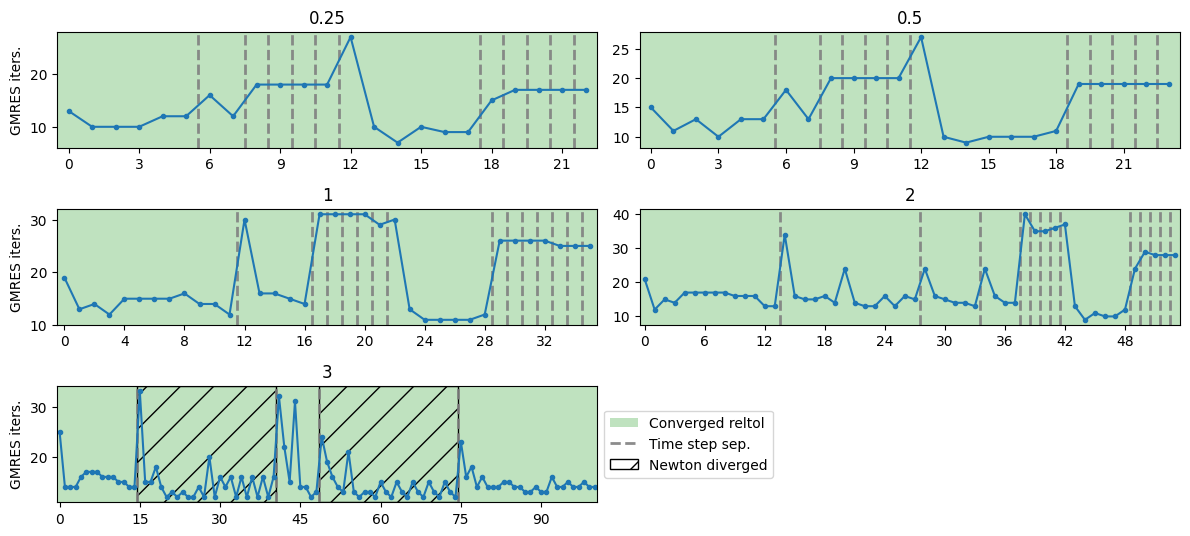

In [10]:
def render_element(entry: Sequence[TimeStepStats]):
    color_converged_reason(entry)
    color_time_steps(entry, fill=False, legend=True)
    plt.gca().grid(False)
    plt.plot(get_gmres_iterations(entry), marker='.')

plot_grid(data, render_element, shape=shape, figsize=figsize, legend=True)

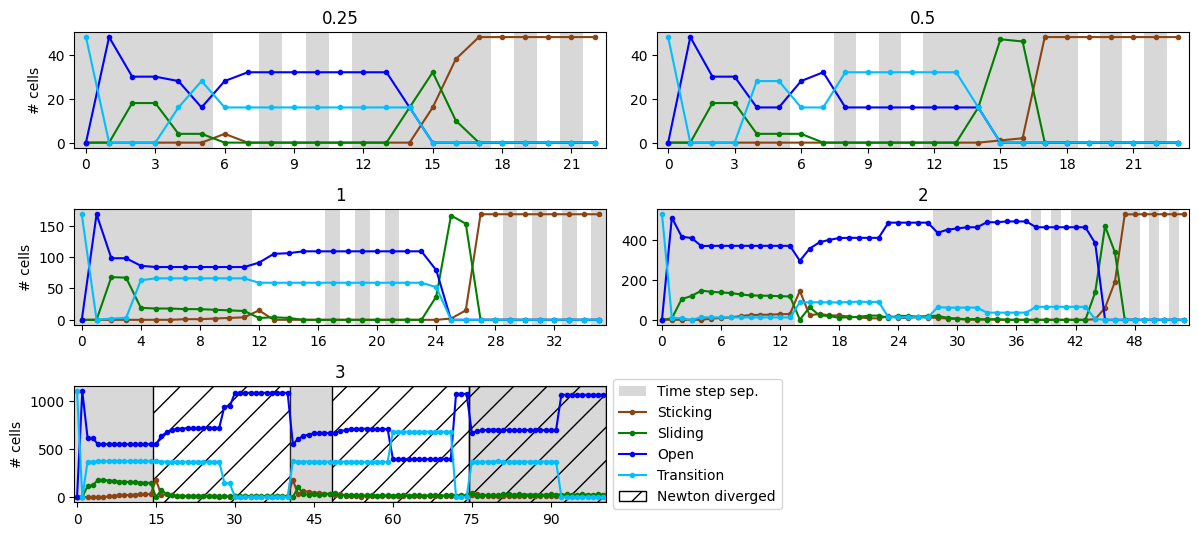

In [11]:
plot_grid(data, plot_sticking_sliding_open_transition, shape=shape, figsize=figsize, ylabel='# cells')

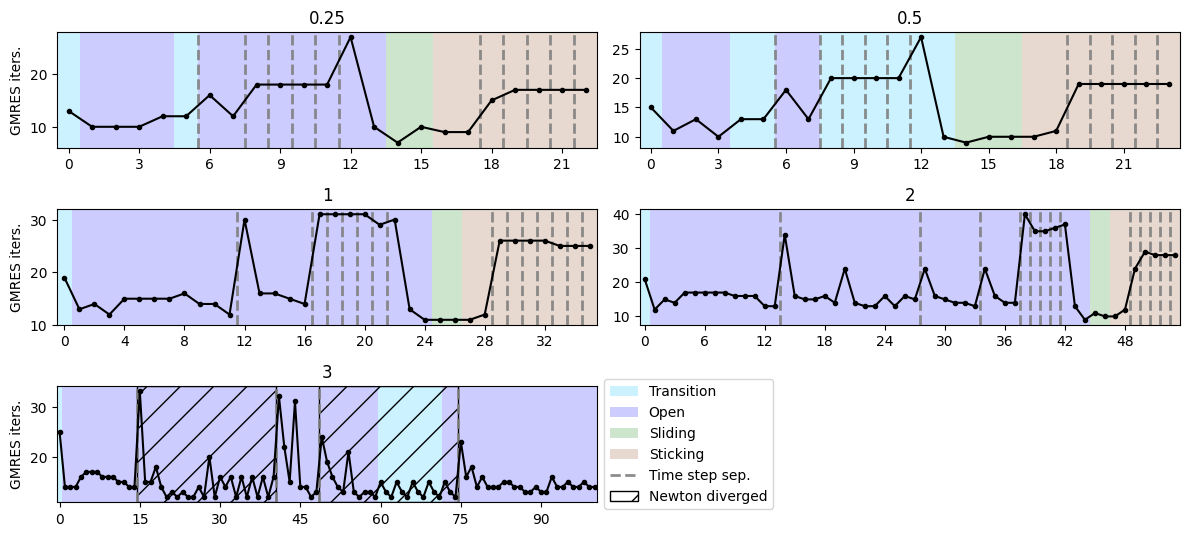

In [12]:
def render_element(entry: Sequence[TimeStepStats]):
    color_sticking_sliding_open_transition(entry)
    color_time_steps(entry, fill=False, legend=True)
    plt.gca().grid(False)
    plt.plot(get_gmres_iterations(entry), marker='.', color='black')

plot_grid(data, render_element, shape=shape, figsize=figsize, legend=True)

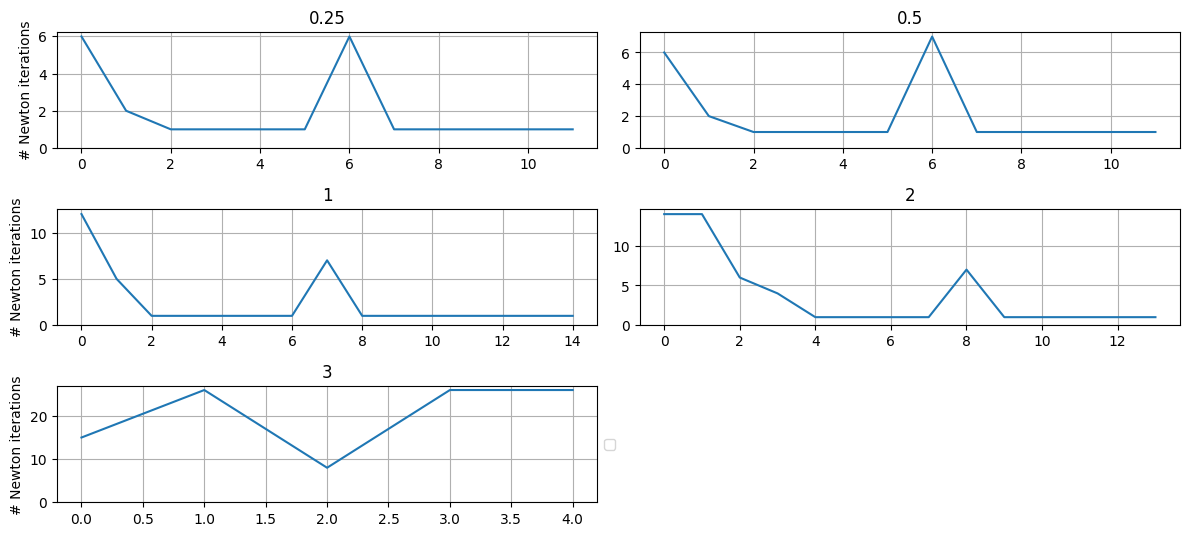

In [13]:
def render_element(entry: Sequence[TimeStepStats]):
    plt.plot(get_newton_iterations(entry))
    plt.ylim(bottom=0)
    plt.grid()

plot_grid(data, render_element, shape=shape, figsize=figsize, ylabel='# Newton iterations', xlabel='time step')

# Testing bad matrix

In [14]:
assert False

AssertionError: 

In [ ]:
from fpm_6 import make_model

cell_size_multiplier = 0.25
model = make_model(cell_size_multiplier)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model._initialize_solver()

cell_size_multiplier = 0.25


num sticking: 0
num sliding: 0
num open: 0
num trans: 48


In [ ]:
mat_idx = 9
entry = data[cell_size_multiplier]
print(get_gmres_iterations(entry)[mat_idx])
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(entry, mat_idx)

61


In [ ]:
model.linear_system = mat, rhs
model.equation_system.set_variable_values(iterate, iterate_index=0)
model.equation_system.set_variable_values(state, time_step_index=0)  # 1

model.ad_time_step.set_value(dt)
st, sl, op, tr = model.sticking_sliding_open_transition()
print(sum(st))
print(sum(sl))
print(sum(op))
print(sum(tr))

0
0
48
0


/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Solve  took: 1.9
True residual permuted: 5.033750633370151e-07
PETSc Converged Reason: -3
lambda min: 0.3587606367019444


{'mat_Q': BlockMatrixStorage of shape (2469, 2469) with 498182 elements with 6x6 active groups}

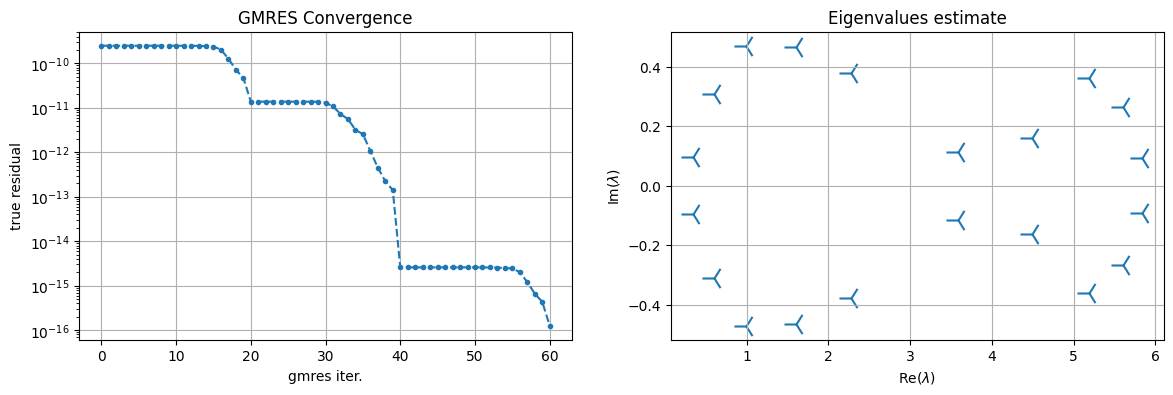

In [ ]:
sol = None
schema = model._prepare_solver()
solve_petsc_new(
    model.bmat,
    schema,
    rhs_global=rhs,
    # Qleft=model.Qleft,
    # Qright=model.Qright,
    pc_side="right",
    tol=1e-10,
)

Solve  took: 0.8
True residual permuted: 8.057019515018391e-07
True residual: 8.059897904088572e-07
PETSc Converged Reason: 2


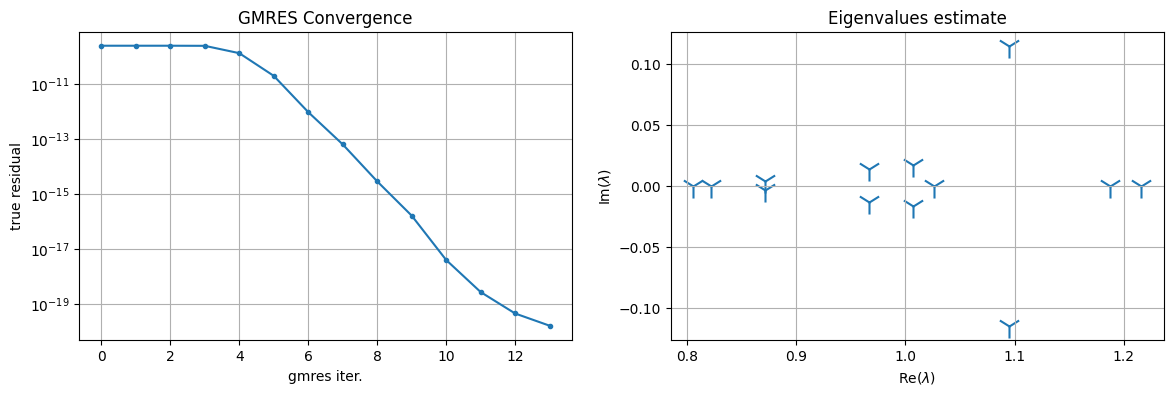

In [ ]:
from block_matrix import SolveSchema, make_solver
from mat_utils import *
from preconditioner_mech import make_J44_inv_bdiag
from fixed_stress import *

schema = SolveSchema(
    groups=[4],
    solve=lambda bmat: inv_block_diag(mat=bmat[[4]].mat, nd=model.nd),
    # only_complement=True,
    complement=SolveSchema(
        groups=[3],
        solve=lambda bmat: PetscILU(bmat[[3]].mat),
        invertor=lambda bmat: extract_diag_inv(bmat[[3]].mat),
        # only_complement=True,
        complement=SolveSchema(
            groups=[5],
            solve=lambda bmat: PetscAMGMechanics(mat=bmat[[5]].mat, dim=model.nd),
            invertor=lambda bmat: inv(bmat[[5]].mat),

            # only_complement=True,
            complement=SolveSchema(
                groups=[1],
                solve=lambda bmat: PetscAMGMechanics(mat=bmat[[1]].mat, dim=model.nd),
                invertor_type="physical",
                invertor=lambda bmat: make_fs_experimental(model, bmat).mat,
                # only_complement=True,
                complement=SolveSchema(
                    groups=[0, 2],
                    solve=lambda bmat: PetscAMGFlow(mat=bmat[[0, 2]].mat),
                ),
            ),
        ),
    ),
)

res = solve_petsc_new(
    model.bmat,
    schema,
    # Qleft=model.Qleft,
    Qright=model.Qright,
    rhs_global=rhs,
    pc_side="right",
    tol=1e-10,
    logx_eigs=False,
)

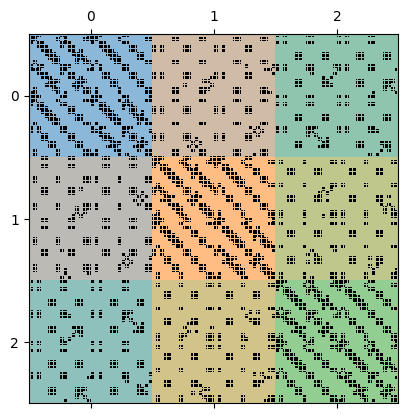

In [ ]:
model.bmat[[5]].color_spy(groups=False, marker=',')

In [ ]:
J55 = model.bmat[[5]]
J55_inv = inv_block_diag(J55.block_diag().mat, nd=model.nd, lump=False)

cond(J55.mat @ J55_inv)

3.544748875651978

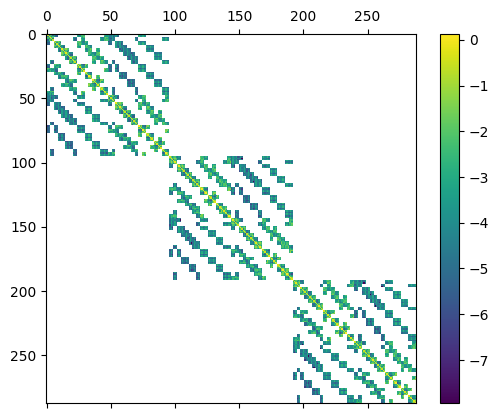

In [ ]:
model.bmat[[5]].block_diag().matshow()

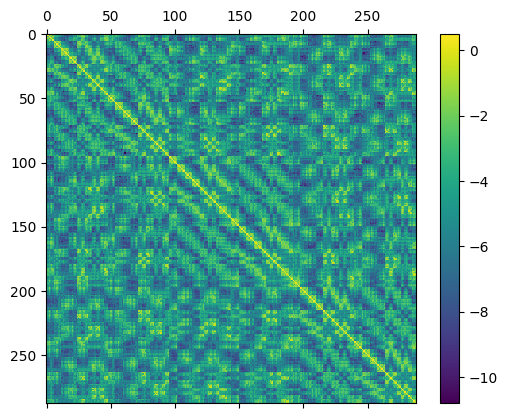

In [ ]:
plot_mat(inv(model.bmat[[5]].mat))